# Praktikum AI - CNN 
## Komang Niko Romano Prodi 
## 222011356 / 3SD1 / 06

In [ ]:
# For tips on running notebooks in Google Colab, see
# https://pytorch.org/tutorials/beginner/colab
%matplotlib inline

## Load and normalize CIFAR10

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms

## Lakukan Split Data dan Load Data

In [ ]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 4

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, 
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)

testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

100%|██████████| 170498071/170498071 [00:03<00:00, 42726232.22it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [ ]:
# jumlah trainset sebelum split data 
print(len(trainset))

50000


In [ ]:
# setting the seeds
import numpy as np
np.random.seed(43)
torch.manual_seed(43)

In [ ]:
# setting seed
def seed_all(seed):
    if not seed:
        seed = 10

    print("[ Using Seed : ", seed, " ]")

    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.cuda.manual_seed(seed)
    numpy.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


In [ ]:
# setting seed 
import numpy
import random

def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    numpy.random.seed(worker_seed)
    random.seed(worker_seed)

g = torch.Generator()
g.manual_seed(43)
num_workers = 2


In [ ]:
# split data trainset sebelumnya menjadi trainset (90%) dan valset (10%)
trainset, valset = torch.utils.data.random_split(trainset, [0.9, 0.1])
print(len(trainset))
print(len(valset))

45000
5000


In [ ]:
# Dataloader trainset, testset, dan valset

# trainloader
trainloader = torch.utils.data.DataLoader(
    trainset,
    batch_size=batch_size,
    num_workers=num_workers,
    worker_init_fn=seed_worker,
    generator=g,
)

# testloader
testloader = torch.utils.data.DataLoader(
    testset,
    batch_size=batch_size,
    num_workers=num_workers,
    worker_init_fn=seed_worker,
    generator=g,
)

#validationloader 
valloader = torch.utils.data.DataLoader(
    valset,
    batch_size=batch_size,
    num_workers=num_workers,
    worker_init_fn=seed_worker,
    generator=g,
)

## Contoh Training Images 

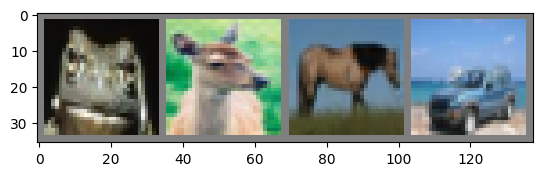

frog  deer  horse car  


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

## Mendefinisikan Model CNN 

In [ ]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 12, 5, stride = 2, padding = 1) # model 7b ganti out channel = 12, model 7c tambah stride = 2, padding = 1
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(12, 16, 5, stride = 2, padding = 1)
        self.fc1 = nn.Linear(16 * 1 * 1, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        # torch.Size([4, 3, 32, 32])
        x = self.pool(F.relu(self.conv1(x))) # (32+2*(0)-5)/1 + 1 = 28, 28/2 = 14 
        #print("pool1", x.size())
        # pool1 torch.Size([4, 6, 14, 14])


        x = self.pool(F.relu(self.conv2(x))) # (14+2*(0)-5)/1 + 1 = 10, 10/2 = 5
        #print("pool2", x.size())
        # pool2 torch.Size([4, 16, 5, 5])


        x = torch.flatten(x, 1) # flatten all dimensions except batch
        #print("flatten", x.size())
        # flatten torch.Size([4, 400])

        x = F.relu(self.fc1(x))
        #print("fc1", x.size())
        # fc1 torch.Size([4, 120])

        x = F.relu(self.fc2(x))
        #print("fc2", x.size())
        # fc2 torch.Size()[4, 84]

        x = self.fc3(x)
        return x


net = Net()
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
net.to(device)

Net(
  (conv1): Conv2d(3, 12, kernel_size=(5, 5), stride=(2, 2), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(12, 16, kernel_size=(5, 5), stride=(2, 2), padding=(1, 1))
  (fc1): Linear(in_features=16, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [ ]:
# Print model's state_dict
print("Model's state_dict:")
for param_tensor in net.state_dict():
  # if param_tensor == 'fc1.weight':
    print(param_tensor, "\t", net.state_dict()[param_tensor].size())

Model's state_dict:
conv1.weight 	 torch.Size([12, 3, 5, 5])
conv1.bias 	 torch.Size([12])
conv2.weight 	 torch.Size([16, 12, 5, 5])
conv2.bias 	 torch.Size([16])
fc1.weight 	 torch.Size([120, 16])
fc1.bias 	 torch.Size([120])
fc2.weight 	 torch.Size([84, 120])
fc2.bias 	 torch.Size([84])
fc3.weight 	 torch.Size([10, 84])
fc3.bias 	 torch.Size([10])


In [ ]:
import torch.optim as optim
net.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [ ]:
n_epoch = 10
val_accuracies = []
max_accu = 0
for epoch in range(n_epoch):  # loop over the dataset multiple times
    
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device), data[1].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
      for data in testloader:
          images, labels = data[0].to(device), data[1].to(device)
          # calculate outputs by running images through the network
          outputs = net(images)
          # the class with the highest energy is what we choose as prediction
          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()
          
    print(f'Epoch : {epoch + 1}: Accuracy of the network on the 5000 val images:{100*correct/ total}' )
    akurasi = 100 * correct / total
    val_accuracies.append(akurasi) 

    #Ambil model dengan akurasi terbaik
    if akurasi >= max_accu:
        torch.save(net.state_dict(),'net_best_accuracy')
        max_accu = akurasi  
print('Finished Training')

[1,  2000] loss: 2.268
[1,  4000] loss: 2.023
[1,  6000] loss: 1.843
[1,  8000] loss: 1.719
[1, 10000] loss: 1.650
Epoch : 1: Accuracy of the network on the 5000 val images:42.08
[2,  2000] loss: 1.544
[2,  4000] loss: 1.550
[2,  6000] loss: 1.534
[2,  8000] loss: 1.477
[2, 10000] loss: 1.468
Epoch : 2: Accuracy of the network on the 5000 val images:47.07
[3,  2000] loss: 1.414
[3,  4000] loss: 1.425
[3,  6000] loss: 1.422
[3,  8000] loss: 1.385
[3, 10000] loss: 1.385
Epoch : 3: Accuracy of the network on the 5000 val images:50.26
[4,  2000] loss: 1.341
[4,  4000] loss: 1.350
[4,  6000] loss: 1.356
[4,  8000] loss: 1.324
[4, 10000] loss: 1.327
Epoch : 4: Accuracy of the network on the 5000 val images:51.77
[5,  2000] loss: 1.292
[5,  4000] loss: 1.310
[5,  6000] loss: 1.311
[5,  8000] loss: 1.288
[5, 10000] loss: 1.286
Epoch : 5: Accuracy of the network on the 5000 val images:51.97
[6,  2000] loss: 1.260
[6,  4000] loss: 1.275
[6,  6000] loss: 1.277
[6,  8000] loss: 1.257
[6, 10000] lo

## Cek Akurasi pada Validation Set

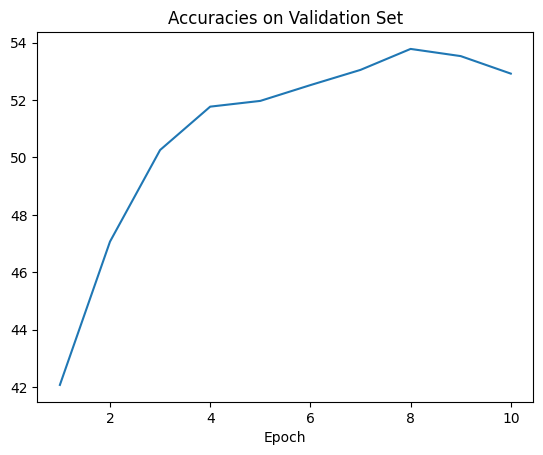

In [ ]:
from matplotlib import pyplot as plt
plt.figure()
plt.xlabel("Epoch")
plt.plot(range(1, len(val_accuracies) + 1), val_accuracies)
plt.title("Accuracies on Validation Set")
plt.show()

In [ ]:
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

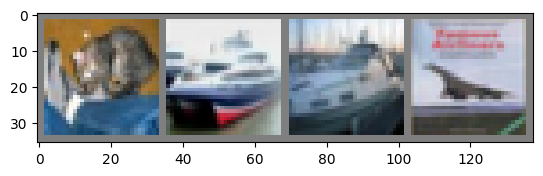

GroundTruth:  cat   ship  ship  plane


In [ ]:
dataiter = iter(testloader)
images, labels = next(dataiter)

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

In [ ]:
net = Net()
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [ ]:
outputs = net(images)

In [ ]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'
                              for j in range(4)))

Predicted:  cat   ship  ship  plane


In [ ]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1) # menggunakan detach() dan cpu()
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 52 %


In [ ]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: plane is 65.0 %
Accuracy for class: car   is 59.7 %
Accuracy for class: bird  is 44.3 %
Accuracy for class: cat   is 33.7 %
Accuracy for class: deer  is 25.8 %
Accuracy for class: dog   is 33.6 %
Accuracy for class: frog  is 82.1 %
Accuracy for class: horse is 68.5 %
Accuracy for class: ship  is 53.6 %
Accuracy for class: truck is 62.9 %


## Cek device yang digunakan 

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Assuming that we are on a CUDA machine, this should print a CUDA device:

print(device) 

cuda:0


In [ ]:
del dataiter